# Library Setup

In [1]:
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data Import and Graph Creation

In [2]:
edges_df = pd.read_csv('../data/gephi-edge-list.csv')
nodes_df = pd.read_csv('../data/gephi-node-list.csv')

G = nx.Graph() 

# Add nodes
for _, row in nodes_df.iterrows():
    node_id = row['ID']
    attributes = row.drop('ID').to_dict()
    G.add_node(node_id, **attributes)

# Add edges with weights
for _, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])

In [3]:
nx.is_connected(G)

False

In [4]:
nx.number_connected_components(G)

2

In [5]:
nx.connected_components(G)

<generator object connected_components at 0x124c7c740>

In [6]:
# Run community detection algorithms, add info to graph and export to gephi for visualization
import networkx.algorithms.community as nxc

# Greedy Modularity
communities = nxc.greedy_modularity_communities(G, weight='Weight')

# add community info to node attributes
i = 0
communities_dict = dict.fromkeys(G.nodes)
for community in communities:
    for player in community:
        communities_dict[player] = i
    i += 1

nx.set_node_attributes(G, communities_dict, "community")

In [7]:
for community in communities:
    print(len(community))

764
642
404
71
60
20
1


In [8]:
nodes_df["community"] = nodes_df["ID"].map(communities_dict)

In [9]:
nodes_df

,ID,name,team,position,college_name,college_conference,fantasy_points,community
0,00-0016919,Adam Vinatieri,NE,K,South Dakota State,Missouri Valley Football Conference,4.0,0
1,00-0022531,Jason Peters,BUF,T,Arkansas,Southeastern Conference,12.0,6
2,00-0022045,Terence Newman,DAL,CB,Kansas State,Big Twelve Conference,6.0,0
3,00-0022923,DeAngelo Hall,ATL,FS,Virginia Tech,Atlantic Coast Conference,0.0,0
4,00-0023252,Robbie Gould,CHI,K,Penn State,Big Ten Conference,0.0,1
...,...,...,...,...,...,...,...,...
1957,00-0039917,Michael Penix,ATL,QB,Washington,Pacific Twelve Conference,44.0,0
1958,00-0039918,Caleb Williams,CHI,QB,Southern California,Pacific Twelve Conference,254.0,1
1959,00-0039919,Rome Odunze,CHI,WR,Washington,Pacific Twelve Conference,90.0,1
1960,00-0039920,Malachi Corley,NYJ,WR,Western Kentucky,Conference USA,4.0,1


In [21]:
node_list_output_path = "../data/gephi-node-list-community.csv"
nodes_df.to_csv(node_list_output_path, index=False)

In [10]:
# Step 1: Group by community and college_name and count occurrences
grouped = nodes_df.groupby(['community', 'college_name']).size().reset_index(name='count')

# Step 2: Get the total count for each community
total_counts = nodes_df.groupby('community').size().reset_index(name='total_count')

# Step 3: Merge to get the total count with the group count
merged = pd.merge(grouped, total_counts, on='community')

# Step 4: Calculate the percentage
merged['percentage'] = (merged['count'] / merged['total_count']) * 100

# Step 5: Sort by percentage and get the top 5 for each community
top_5_teams = merged.sort_values(by=['community', 'percentage'], ascending=[True, False]) \
                    .groupby('community').head(5)

# Show the result
print(top_5_teams[['community', 'college_name', 'percentage']])

     community     college_name  percentage
198          0       Washington    2.486911
3            0          Alabama    2.225131
130          0         Oklahoma    1.832461
155          0   South Carolina    1.701571
166          0         Stanford    1.701571
329          1       Ohio State    2.959502
214          1          Alabama    2.492212
327          1       Notre Dame    2.180685
335          1       Penn State    2.024922
303          1            Miami    1.869159
444          2          Georgia    3.465347
524          2        Tennessee    2.970297
442          2    Florida State    2.227723
464          2  Louisiana State    2.227723
500          2         Oklahoma    2.227723
579          3         Missouri    4.225352
562          3       California    2.816901
564          3      Connecticut    2.816901
566          3    Florida State    2.816901
567          3          Georgia    2.816901
629          4  Louisiana State    5.000000
632          4         Michigan 

In [11]:
top_5_teams

,community,college_name,count,total_count,percentage
198,0,Washington,19,764,2.486911
3,0,Alabama,17,764,2.225131
130,0,Oklahoma,14,764,1.832461
155,0,South Carolina,13,764,1.701571
166,0,Stanford,13,764,1.701571
329,1,Ohio State,19,642,2.959502
214,1,Alabama,16,642,2.492212
327,1,Notre Dame,14,642,2.180685
335,1,Penn State,13,642,2.024922
303,1,Miami,12,642,1.869159


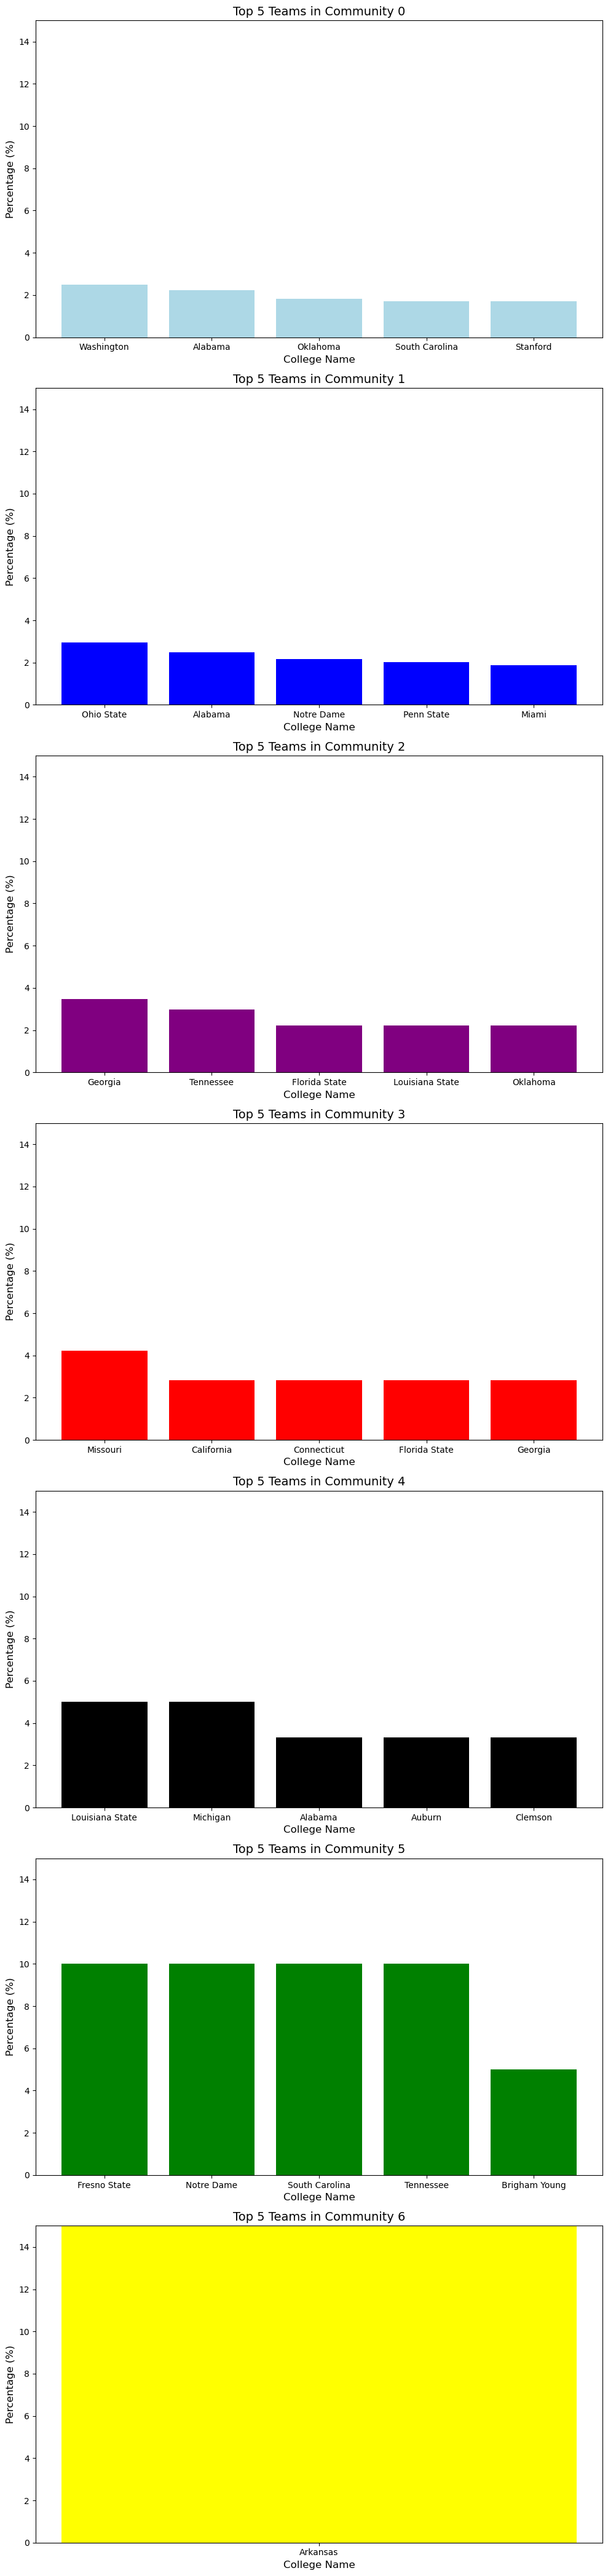

In [12]:
# Step 6: Plot the bar graph for each community
fig, axes = plt.subplots(nrows=len(top_5_teams['community'].unique()), ncols=1, figsize=(10, 6 * len(top_5_teams['community'].unique())))
colors = ['lightblue', 'blue', 'purple', 'red', 'black', 'green', 'yellow']

# If there's only one community, make sure axes is not a 2D array
if len(top_5_teams['community'].unique()) == 1:
    axes = [axes]

for ax, community in zip(axes, top_5_teams['community'].unique()):
    # Filter data for each community
    community_data = top_5_teams[top_5_teams['community'] == community]
    
    # Plotting
    ax.bar(community_data['college_name'], community_data['percentage'], color=colors[community])
    
    # Adding labels and title
    ax.set_title(f"Top 5 Teams in Community {community}", fontsize=14)
    ax.set_xlabel('College Name', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 15)  # To ensure the y-axis goes from 0 to 100%

# Adjust layout
plt.tight_layout()
plt.show()

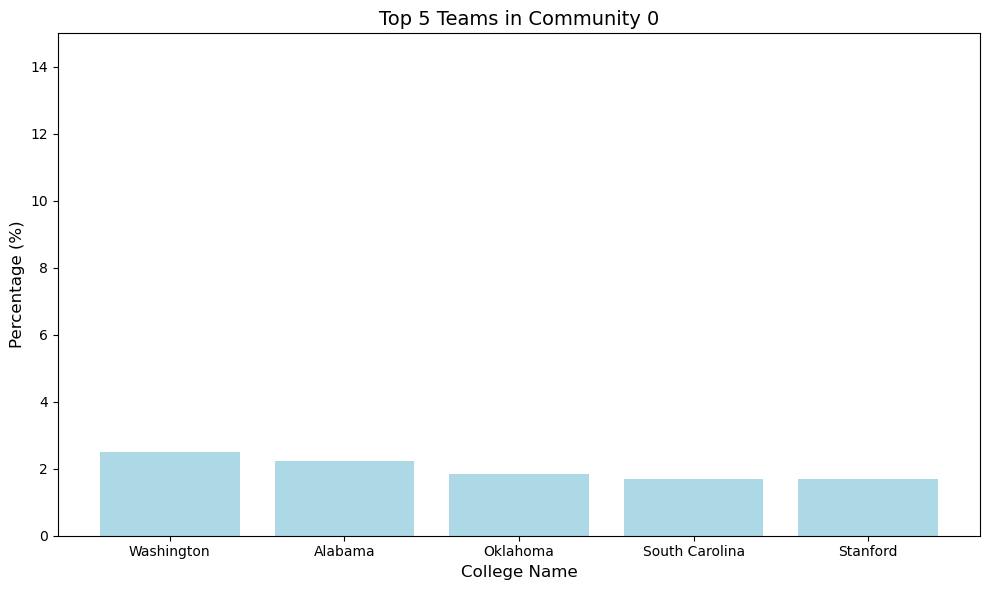

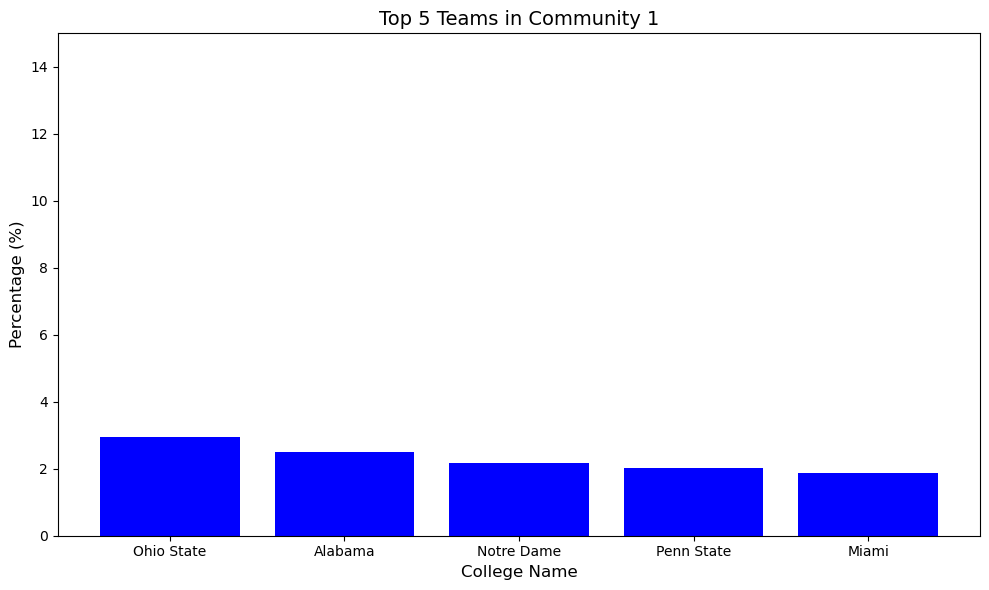

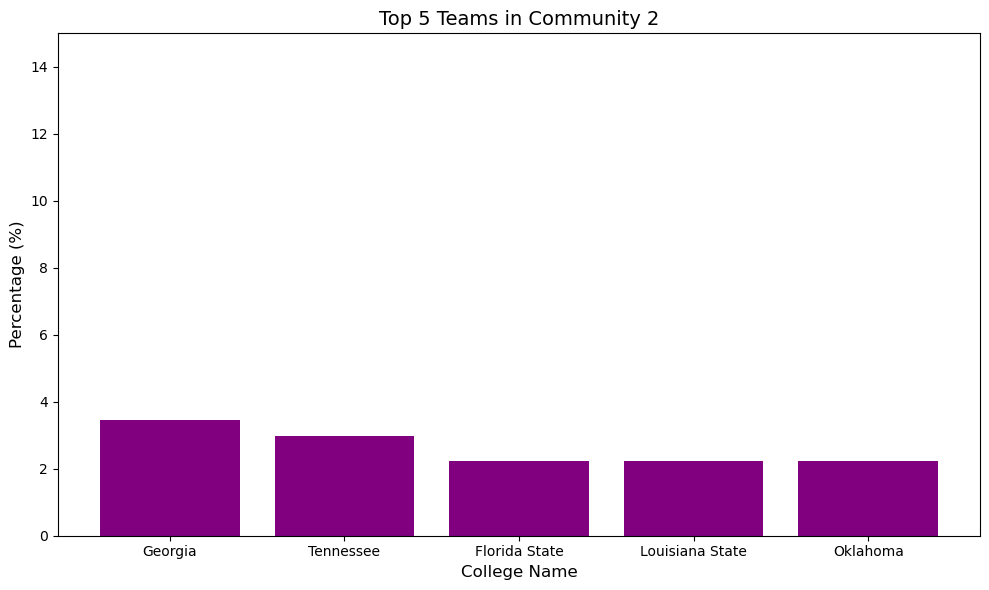

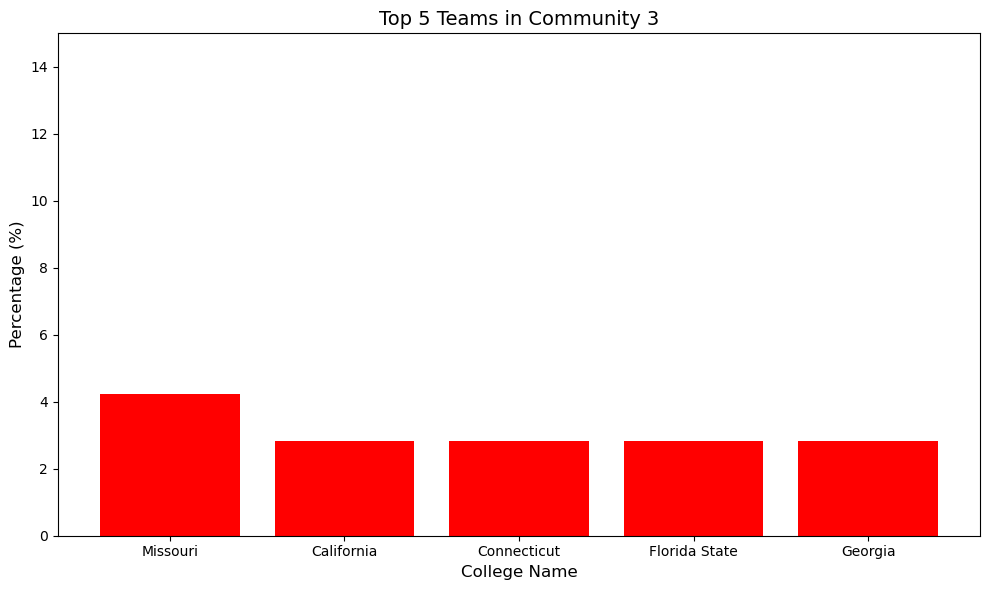

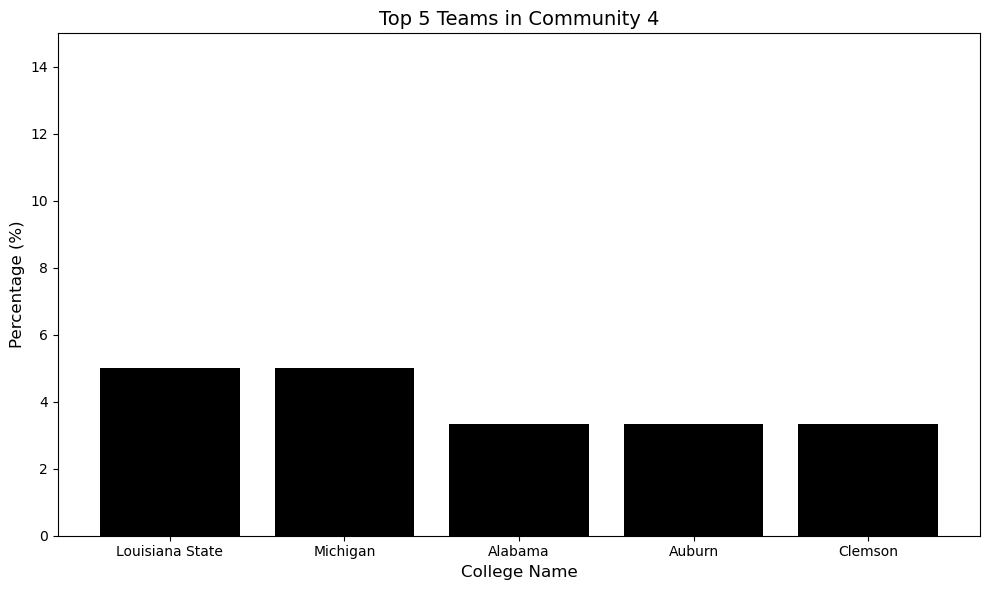

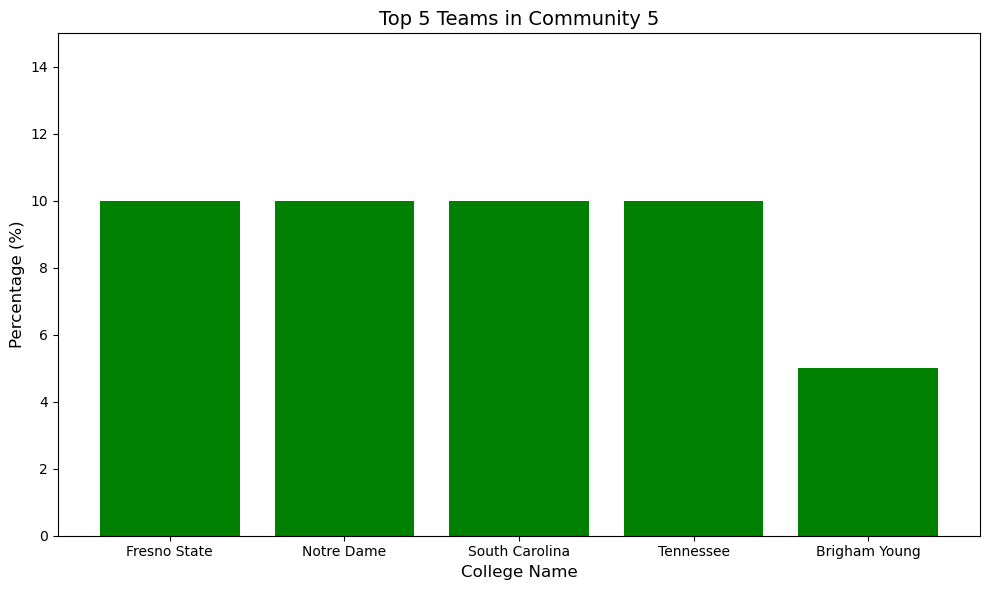

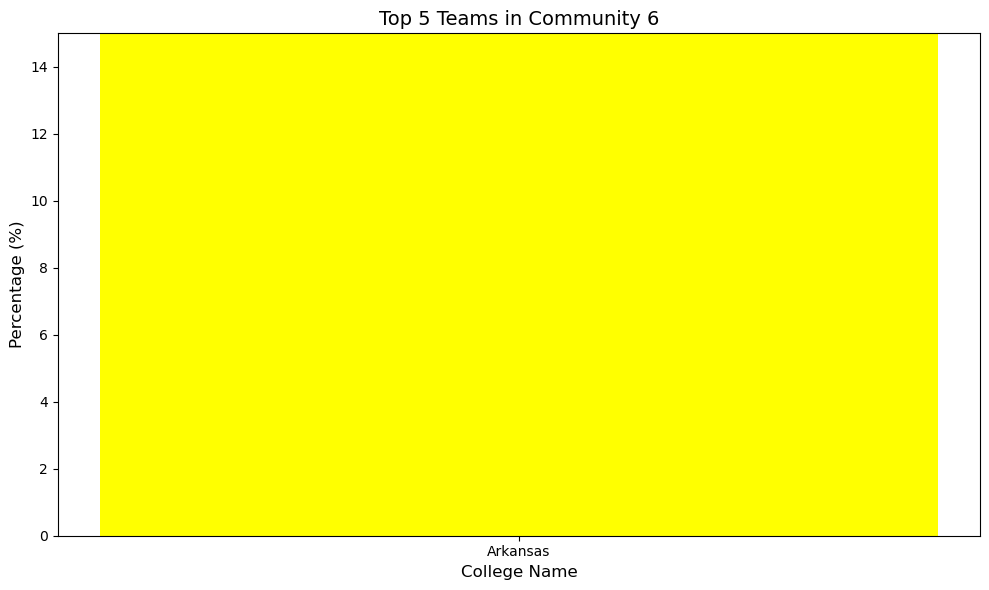

In [20]:
colors = ['lightblue', 'blue', 'purple', 'red', 'black', 'green', 'yellow']

# Iterate over each unique community
for community in top_5_teams['community'].unique():
    # Filter data for the current community
    community_data = top_5_teams[top_5_teams['community'] == community]
    
    # Create a new figure for each community
    plt.figure(figsize=(10, 6))
    
    # Plotting the bar graph
    plt.bar(community_data['college_name'], community_data['percentage'], color=colors[community])
    
    # Adding labels and title
    plt.title(f"Top 5 Teams in Community {community}", fontsize=14)
    plt.xlabel('College Name', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.ylim(0, 15)  # Ensure the y-axis goes from 0 to 100%
    
    # Show the plot for the current community
    plt.tight_layout()
    plt.show()

In [13]:
Modularity = nx.community.modularity(G, communities)
print(Modularity)

0.3046409581311695


# Comparing to an Erdös-Renyi graph of similar size

In [14]:
# Function Defintions

# Function to plot a degree distribution graph (P(k) vs k graph)
def plot_degree_dist(G):
    
    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=20)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=20)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6,4))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

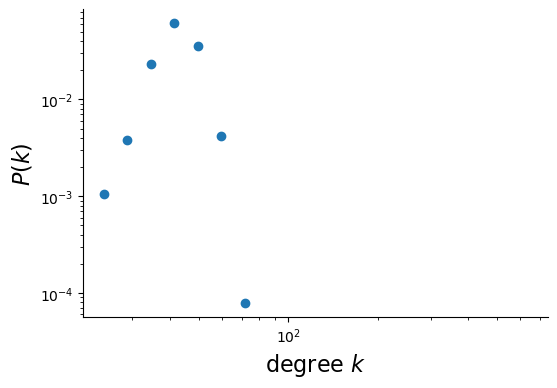

In [15]:
GN = len(G.nodes()) # G.number_of_nodes()
max_L = GN*(GN-1)/2
actual_L = len(G.edges())
p = actual_L/max_L

ER = nx.erdos_renyi_graph(GN, p, directed=False)

plot_degree_dist(ER)

In [17]:
clustering_ER = []
short_path_ER = []
modularity_ER = []

for i in range(100): # 1000 is better
    
    ER = nx.erdos_renyi_graph(GN, p, directed=False)
    
    communities_ER = nxc.greedy_modularity_communities(ER)
    M_ER = nx.community.modularity(ER, communities_ER)

    # C_ER = np.mean(list(nx.clustering(ER).values()))
    # if nx.is_connected(ER)==True:
    #     d_ER = nx.average_shortest_path_length(ER,weight=None)

    modularity_ER.append(M_ER)
#     clustering_ER.append(C_ER)
#     short_path_ER.append(d_ER)
    
# print(np.mean(clustering_ER))
# print(np.std(clustering_ER))

# print(np.mean(short_path_ER))
# print(np.std(short_path_ER))

print(np.mean(modularity_ER))
print(np.std(modularity_ER))

0.11985704462719754
0.0013882880437484893


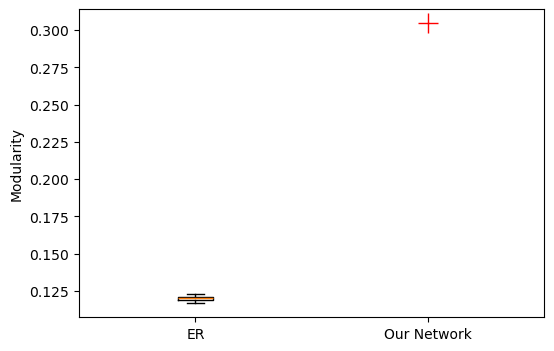

In [19]:
fig = plt.figure(figsize=(6,4))

plt.boxplot(modularity_ER)
plt.plot(2,Modularity,'r',marker='+',markersize=15)
ax = plt.gca()
ax.set_xticks([1,2],labels=['ER','Our Network'])
plt.ylabel('Modularity')
plt.xlim([0.5,2.5])
plt.show()